In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from shap import plots, Explanation, DeepExplainer
from sklearn.preprocessing import StandardScaler
import time
import shap
from tqdm import tqdm
import pickle
from sklearn.cluster import KMeans
from utils import *
from mlp import MLP
import torch
from yellowbrick.model_selection import LearningCurve

pd.set_option('display.max_columns', None)


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Check for GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Here I force the model to run on cpu since it's a small one is goes faster on a cpu then a gpu
device = 'cpu'

In [3]:
# you should run making_hikari2022_csv.ipynb before running this cell, since the two csv given with the paper have two differences
# to see what are the data types and the features of the dataset, you can take a look on the utils file
ds = pd.concat([
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2021.csv', dtype=dtype_dict, usecols=selected_features),
    pd.read_csv('datasets/HIKARI-2021/ALLFLOWMETER_HIKARI2022.csv', dtype=dtype_dict, usecols=selected_features)], 
    ignore_index=True)
ds.head()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,traffic_category,Label
0,2.207588,15,14,6,6,6.794746,6.341763,13.136509,0.933333,464,20,40,492,32,44,2,2,2,6,5,26,0,0,0,0,0,742,1826.0,121.733333,220.736581,0,1448,5025.0,358.928571,552.239840,0,1448,6851.0,236.241379,424.859275,18.119812,1.963762e+06,2.207603e+06,1.576859e+05,5.205052e+05,7.867813,2.032929e+06,2.177950e+06,1.675346e+05,5.606267e+05,7.867813,1.963762e+06,2.207603e+06,78842.963491,3.696378e+05,3103.387105,7.5,7.0,913.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.207603e+06,2.207603e+06,2.207603e+06,2.207603e+06,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,29200,65160,0,Bruteforce-XML,True
1,15.624266,15,14,6,6,0.960045,0.896042,1.856087,0.933333,488,20,44,468,32,44,2,2,2,6,5,26,0,0,0,0,0,745,1829.0,121.933333,221.339257,0,1448,5025.0,358.928571,552.239840,0,1448,6854.0,236.344828,424.987166,20.980835,1.534300e+07,1.562428e+07,1.116020e+06,4.094889e+06,20.980835,1.541144e+07,1.559517e+07,1.199628e+06,4.270148e+06,10.013580,1.534300e+07,1.562428e+07,558009.896960,2.897622e+06,438.676603,7.5,7.0,914.5,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.883792e+04,2.524381e+05,2.812760e+05,1.406380e+05,158109.181742,1.534300e+07,1.534300e+07,1.534300e+07,1.534300e+07,0.0,29200,65160,0,Bruteforce-XML,True
2,12.203357,14,13,6,5,1.147225,1.065281,2.212506,0.928571,432,20,40,448,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,36.001205,1.196814e+07,1.220338e+07,9.387216e+05,3.314032e+06,15.020370,1.203674e+07,1.217482e+07,1.014569e+06,3.471107e+06,15.020370,1.196814e+07,1.220338e+07,469360.810060,2.345336e+06,561.566789,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.891302e+04,2.063251e+05,2.352381e+05,1.176190e+05,125449.251656,1.196814e+07,1.196814e+07,1.196814e+07,1.196814e+07,0.0,29200,65160,0,Bruteforce-XML,True
3,9.992448,14,13,6,5,1.401058,1.300983,2.702041,0.928571,432,20,40,436,32,44,2,2,2,6,5,24,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,386.538462,817.479013,0,2896,6853.0,253.814815,592.570284,50.067902,9.759205e+06,9.992470e+06,7.686515e+05,2.701448e+06,20.980835,9.828447e+06,9.963348e+06,8.302790e+05,2.833716e+06,20.980835,9.759205e+06,9.992470e+06,384325.770231,1.912152e+06,685.817940,7.0,6.5,914.0,2512.5,0.0,0.0,0.0,0.0,0.0,0.0,2.952909e+04,2.037361e+05,2.332652e+05,1.166326e+05,123182.931318,9.759205e+06,9.759205e+06,9.759205e+06,9.759205e+06,0.0,29200,65160,0,Bruteforce-XML,True
4,7.780611,14,14,6,5,1.799345,1.799345,3.598689,1.000000,432,20,40,480,32,44,2,2,2,6,5,25,0,0,0,0,0,744,1828.0,130.571429,226.803444,0,2896,5025.0,358.928571,792.173394,0,2896,6853.0,244.750000,583.468215,16.927719,7.545305e+06,7.780620e+06,5.985092e+

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783531 entries, 0 to 783530
Data columns (total 81 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   flow_duration             783531 non-null  float64
 1   fwd_pkts_tot              783531 non-null  uint64 
 2   bwd_pkts_tot              783531 non-null  uint64 
 3   fwd_data_pkts_tot         783531 non-null  uint64 
 4   bwd_data_pkts_tot         783531 non-null  uint64 
 5   fwd_pkts_per_sec          783531 non-null  float64
 6   bwd_pkts_per_sec          783531 non-null  float64
 7   flow_pkts_per_sec         783531 non-null  float64
 8   down_up_ratio             783531 non-null  float32
 9   fwd_header_size_tot       783531 non-null  uint64 
 10  fwd_header_size_min       783531 non-null  uint8  
 11  fwd_header_size_max       783531 non-null  uint8  
 12  bwd_header_size_tot       783531 non-null  uint64 
 13  bwd_header_size_min       783531 non-null  u

In [5]:
ds.describe()

,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,flow_pkts_payload.avg,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,7.835310e+05,783531.000000,783531.000000,7.835310e+05,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,7.835310e+05,783531.000000,783531.000000,783531.000000
mean,7.930232,15.141476,15.202140,6.076205,11.985713,3.475753e+03,2.813504e+03,6.284778e+03,1.975985,5.221322e+02,23.148409,28.325925,4.665602e+02,18.626142,22.381593,0.778524,1.156447,0.418391,5.386756,8.314095,28.377589,0.001020,0.000008,0.001668,0.000037,17.793925,193.943558,1.685628e+03,1.054549e+02,54.541936,22.216197,1167.560257,1.975559e+04,5.381859e+02,3.519654e+02,17.805741,1178.124581,2.144121e+04,4.416836e+02,2.990518e+02,8.931155e+05,5.733389e+06,8.904876e+06,1.332912e+06,1.162227e+06,2.537420e+04,4.618173e+06,6.764059e+06,4.246261e+05,1.293048e+06,8.930607e+05,6.085861e+06,1.011627e+07,1.260414e+06,8.197949e+05,8.433863e+04,10.925990,11.081897,1159.948376,1.210176e+04,9.029155e+01,4.742144e+03,0.043071,1.864668,6.219484e+03,4.148455e+06,8.041311e+05,1.059131e+06,1.148116e+06,8.946945e+05,1.179072e+05,4.571039e+06,5.764442e+06,8.678673e+06,5.109868e+06,6.037600e+05,25885.029520,26880.533083,7417.383553
std,97.220072,390.717612,395.026085,62.401492,393.515497,1.696581e+05,1.579508e+05,3.246767e+05,31.937681,1.484319e+04,12.629693,15.981276,1.259048e+04,12.781371,16.568396,0.999198,1.029890,0.812277,62.129340,145.891623,785.296047,0.032707,0.002767,0.048602,0.006490,32.828224,300.906381,6.378143e+04,3.639657e+03,351.378688,43.025812,2464.742493,3.385688e+05,1.639081e+04,2.860092e+03,32.883272,2464.226347,3.469619e+05,1.280389e+04,4.456432e+03,6.836720e+07,2.356495e+08,2.966493e+08,9.935204e+07,6.019453e+07,1.451423e+06,2.256559e+08,1.885185e+08,2.769771e+07,1.059583e+08,6.836746e+07,3.022425e+08,7.036060e+08,1.011819e+08,3.227715e+07,5.690312e+06,73.305702,80.394173,14522.031819,1.

In [6]:
ds.columns

Index(['flow_duration', 'fwd_pkts_tot', 'bwd_pkts_tot', 'fwd_data_pkts_tot',
       'bwd_data_pkts_tot', 'fwd_pkts_per_sec', 'bwd_pkts_per_sec',
       'flow_pkts_per_sec', 'down_up_ratio', 'fwd_header_size_tot',
       'fwd_header_size_min', 'fwd_header_size_max', 'bwd_header_size_tot',
       'bwd_header_size_min', 'bwd_header_size_max', 'flow_FIN_flag_count',
       'flow_SYN_flag_count', 'flow_RST_flag_count', 'fwd_PSH_flag_count',
       'bwd_PSH_flag_count', 'flow_ACK_flag_count', 'fwd_URG_flag_count',
       'bwd_URG_flag_count', 'flow_CWR_flag_count', 'flow_ECE_flag_count',
       'fwd_pkts_payload.min', 'fwd_pkts_payload.max', 'fwd_pkts_payload.tot',
       'fwd_pkts_payload.avg', 'fwd_pkts_payload.std', 'bwd_pkts_payload.min',
       'bwd_pkts_payload.max', 'bwd_pkts_payload.tot', 'bwd_pkts_payload.avg',
       'bwd_pkts_payload.std', 'flow_pkts_payload.min',
       'flow_pkts_payload.max', 'flow_pkts_payload.tot',
       'flow_pkts_payload.avg', 'flow_pkts_payload.std', 'fwd

We can see from this graph that we don't have highly correlated features.

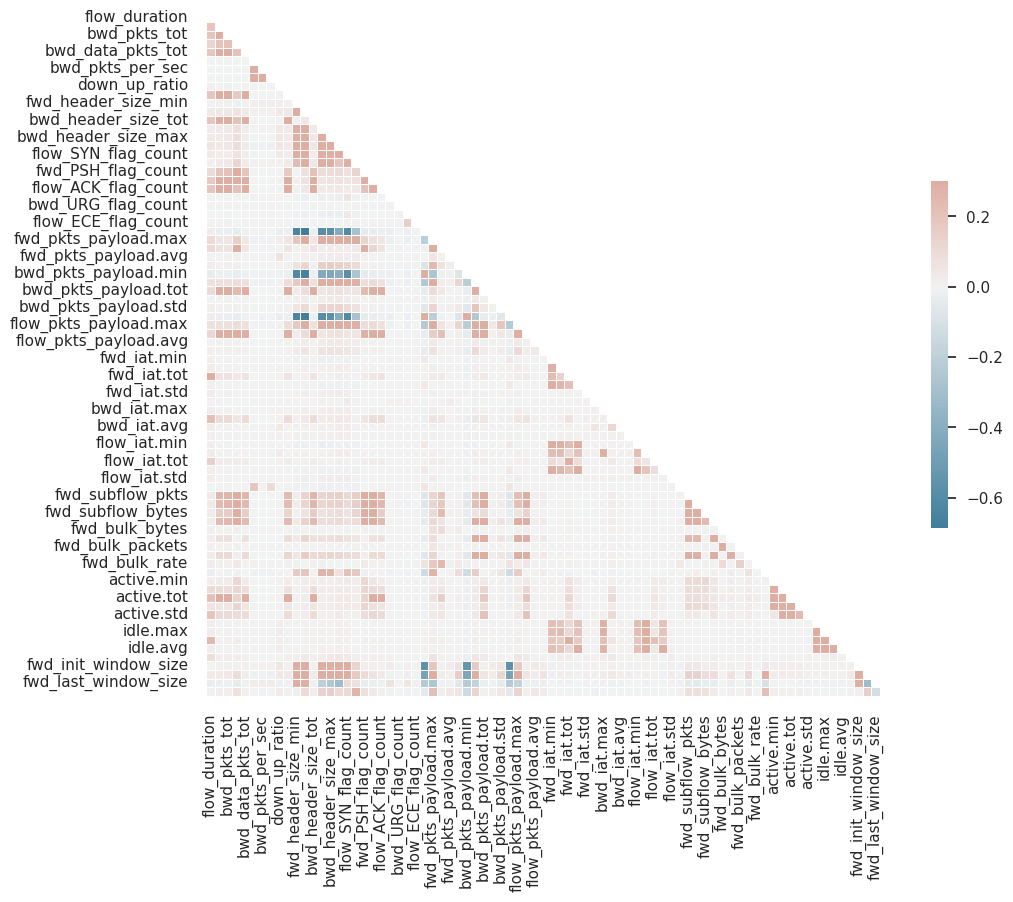

In [7]:
show_corr_matrix(ds)

In [8]:
compute_ratio(ds)

                     Ratio
traffic_category          
Benign               71.77
Background           21.72
Probing               2.98
XMRIGCC CryptoMiner   1.39
Bruteforce-XML        1.12
Bruteforce            1.02


ricordarsi di fare fit una volta sola per tutti i dati e poi usare transform dove serve

In [9]:
scaler = StandardScaler()
scaler.fit(ds[x_features])

StandardScaler()

In [10]:
model = MLP(epoch=320, verbose=True)

params = {
    'epoch': 320,
    'verbose': False,
    'n_features': 79
}

pv = DataPreprocessingAndValidation(ds, 7988, 5, MLP, params, scaler)

In [11]:
X_res, y_res = pv.get_undersampled_ds()
scaled_X_res = scaler.transform(X_res)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X_res, ds.loc[y_res.index].Label, test_size = 0.2, random_state=12,  stratify=ds.loc[y_res.index].traffic_category)

Epoch [1/320], Loss: 0.6078464388847351
Epoch [2/320], Loss: 0.4611886143684387
Epoch [3/320], Loss: 0.34615299105644226
Epoch [4/320], Loss: 0.30805733799934387
Epoch [5/320], Loss: 0.2896508276462555
Epoch [6/320], Loss: 0.2780197262763977
Epoch [7/320], Loss: 0.26885658502578735
Epoch [8/320], Loss: 0.261063814163208
Epoch [9/320], Loss: 0.2550278604030609
Epoch [10/320], Loss: 0.24826182425022125
Epoch [11/320], Loss: 0.2440621554851532
Epoch [12/320], Loss: 0.23973576724529266
Epoch [13/320], Loss: 0.2361101359128952
Epoch [14/320], Loss: 0.23421138525009155
Epoch [15/320], Loss: 0.2327599674463272
Epoch [16/320], Loss: 0.2312188446521759
Epoch [17/320], Loss: 0.2298898845911026
Epoch [18/320], Loss: 0.2286563664674759
Epoch [19/320], Loss: 0.22774428129196167
Epoch [20/320], Loss: 0.2264447659254074
Epoch [21/320], Loss: 0.2256527543067932
Epoch [22/320], Loss: 0.2242174595594406
Epoch [23/320], Loss: 0.22377096116542816
Epoch [24/320], Loss: 0.22260509431362152
Epoch [25/320], L

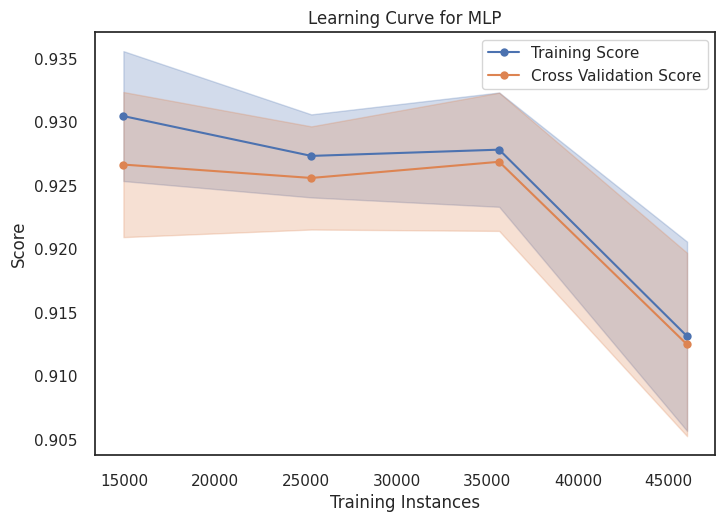

In [14]:
if True:
    cv = 10
    visualizer = LearningCurve(estimator=model, cv=cv, scoring='f1', n_jobs=1, random_state=123)
    visualizer.fit(X_train, y_train)
    visualizer.show(outpath="mlp_data/learning_curve.png")


In [15]:
%time pv.cross_validation(ds[x_features], ds.Label, y_res)

Running the stratified 5-fold
Test and Train k-fold created
setting the first layer to 79 neurons
Running the cross validation
No improvement for 10 epochs, stopping.
Execution time:  8.716667175292969
No improvement for 10 epochs, stopping.
Execution time:  4.431168794631958
No improvement for 10 epochs, stopping.
Execution time:  5.1556103229522705
No improvement for 10 epochs, stopping.
Execution time:  109.98541283607483
No improvement for 10 epochs, stopping.
Execution time:  22.286330938339233
CPU times: user 23min 57s, sys: 12.8 s, total: 24min 10s
Wall time: 3min 40s


(0.9257306847475666, 0.0057720552208965215, 151.2024552822113)

In [14]:
model.fit(X_train, y_train)

Epoch [1/320], Loss: 0.6672766208648682
Epoch [2/320], Loss: 0.4263365566730499
Epoch [3/320], Loss: 0.35265716910362244
Epoch [4/320], Loss: 0.3325398862361908
Epoch [5/320], Loss: 0.3155737817287445
Epoch [6/320], Loss: 0.29897579550743103
Epoch [7/320], Loss: 0.2863579988479614
Epoch [8/320], Loss: 0.2740395963191986
Epoch [9/320], Loss: 0.2637251615524292
Epoch [10/320], Loss: 0.2560817003250122
Epoch [11/320], Loss: 0.2500420808792114
Epoch [12/320], Loss: 0.244314506649971
Epoch [13/320], Loss: 0.2394305169582367
Epoch [14/320], Loss: 0.23499172925949097
Epoch [15/320], Loss: 0.23028741776943207
Epoch [16/320], Loss: 0.22876612842082977
Epoch [17/320], Loss: 0.2244485765695572
Epoch [18/320], Loss: 0.22357454895973206
Epoch [19/320], Loss: 0.22077018022537231
Epoch [20/320], Loss: 0.21974113583564758
Epoch [21/320], Loss: 0.21913732588291168
Epoch [22/320], Loss: 0.21708601713180542
Epoch [23/320], Loss: 0.2164963185787201
Epoch [24/320], Loss: 0.21667371690273285
Epoch [25/320],

In [15]:
y_predicted_test = model.predict(X_test)
y_predicted_train = model.predict(X_train)

In [16]:
performanceMetricsDF(metrics, y_train, y_predicted_train, y_test, y_predicted_test)

,Measure,Train,Test
0,ACCURACY,0.924144,0.922307
1,PRECISION,0.876428,0.874653
2,RECALL,0.987520,0.985918
3,F1 SCORE,0.928663,0.926958
4,AUC,0.924145,0.922302


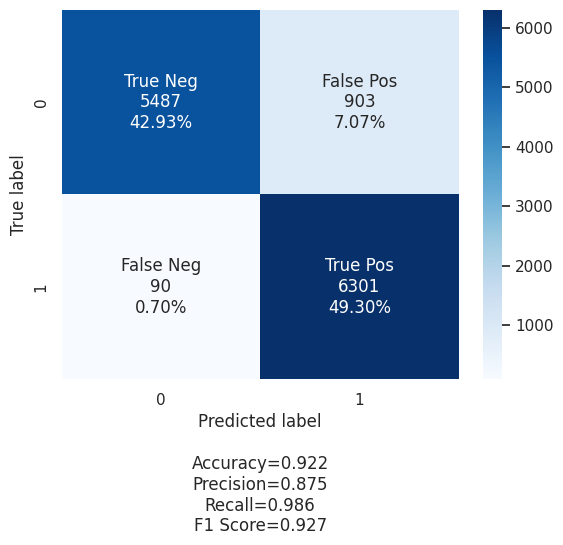

In [17]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_predicted_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories,
                      cmap='Blues')

In [18]:
scaled_X_train = scaler.transform(X_train)

X does not have valid feature names, but StandardScaler was fitted with feature names


In [19]:
cluster_centers = KMeans(n_clusters=1000, random_state=0).fit(scaled_X_train).cluster_centers_
cluster_centers = torch.from_numpy(cluster_centers.astype(np.float32)).to(device)

foreground = shap.sample(X_train, 1000)
foreground_tensor = torch.from_numpy(foreground.astype(np.float32)).to(device)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [20]:
%%time

explainer = DeepExplainer(model, cluster_centers)
sv = explainer.shap_values(foreground_tensor)

exp = Explanation(sv,
              explainer.expected_value,
              data=foreground, 
              feature_names=x_features)

CPU times: user 1min 10s, sys: 90.8 ms, total: 1min 10s
Wall time: 21 s


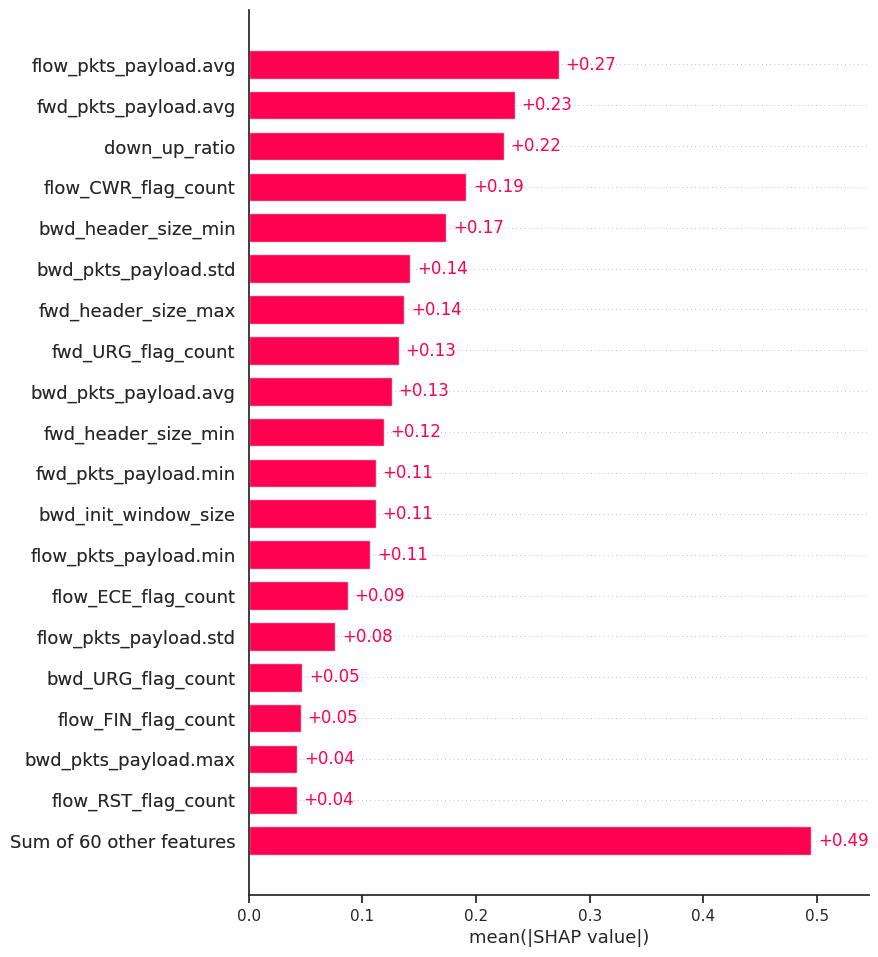

In [21]:
plots.bar(exp, max_display=20, show=False)
plt.show()

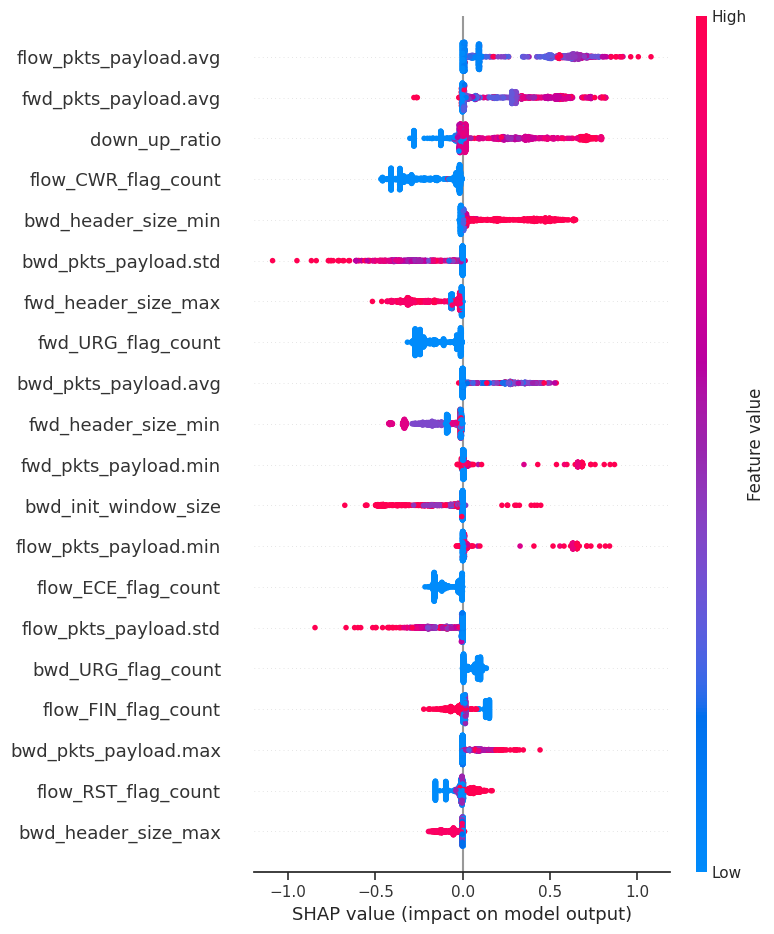

In [22]:
shap.summary_plot(exp, max_display=20)

In [23]:
pv.feature_importance = pd.DataFrame(data={'importance' : exp.abs.mean(0).values, 'feature': x_features})
pv.feature_importance.sort_values('importance',ascending=False).head(20)

,importance,feature
38,0.273041,flow_pkts_payload.avg
28,0.234300,fwd_pkts_payload.avg
8,0.224190,down_up_ratio
23,0.191287,flow_CWR_flag_count
13,0.173833,bwd_header_size_min
34,0.142178,bwd_pkts_payload.std
11,0.136861,fwd_header_size_max
21,0.132264,fwd_URG_flag_count
33,0.125823,bwd_pkts_payload.avg
10,0.119055,fwd_header_size_min


In [24]:
pv.feature_above_zero = pv.feature_importance.query('importance > 0').sort_values('importance',ascending=False)['feature'].to_list()

In [29]:
%%time

if True:
    result = pv.recursive_reduction()
    feature_reduction_scores = pd.DataFrame({'F1_score': result[0], 'score_std': result[1], 'n_features': result[2], 'cv_time': result[3]})
    
    with open('mlp_data/feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('mlp_data/feature_reduction_scores.pickle', 'rb') as handle:
        feature_reduction_scores = pickle.load(handle)

setting the number of features to  1
Running the cross validation
Epoch [1/320], Loss: 0.6839489936828613
Epoch [2/320], Loss: 0.672910213470459
Epoch [3/320], Loss: 0.6345863342285156
Epoch [4/320], Loss: 0.6120916604995728
Epoch [5/320], Loss: 0.5902271270751953
Epoch [6/320], Loss: 0.57209712266922
Epoch [7/320], Loss: 0.5567309260368347
Epoch [8/320], Loss: 0.5420465469360352
Epoch [9/320], Loss: 0.5290637612342834
Epoch [10/320], Loss: 0.5168313384056091
Epoch [11/320], Loss: 0.5056961178779602
Epoch [12/320], Loss: 0.4962237477302551
Epoch [13/320], Loss: 0.4873112738132477
Epoch [14/320], Loss: 0.4801746606826782
Epoch [15/320], Loss: 0.4749619960784912
Epoch [16/320], Loss: 0.4722832143306732
Epoch [17/320], Loss: 0.4703068137168884
Epoch [18/320], Loss: 0.46908479928970337
Epoch [19/320], Loss: 0.4683288633823395
Epoch [20/320], Loss: 0.46761754155158997
Epoch [21/320], Loss: 0.466457724571228
Epoch [22/320], Loss: 0.4653145968914032
Epoch [23/320], Loss: 0.4653313457965851
Ep

KeyboardInterrupt: 

In [25]:
%%time

if True:
    zero_day_feature_reduction_scores = pv.run_zero_day_test()
    with open('mlp_data/zero_day_feature_reduction_scores.pickle', 'wb') as handle:
        pickle.dump(zero_day_feature_reduction_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('mlp_data/zero_day_feature_reduction_scores.pickle', 'rb') as handle:
        zero_day_feature_reduction_scores = pickle.load(handle)

traing for  XMRIGCC CryptoMiner
training with 79 features
Running the stratified 5-fold
Test and Train k-fold created
setting the first layer to 79 neurons
Running the cross validation
Epoch [1/320], Loss: 0.5053450465202332
Epoch [2/320], Loss: 0.37167832255363464
Epoch [3/320], Loss: 0.3147859275341034
Epoch [4/320], Loss: 0.28170719742774963
Epoch [5/320], Loss: 0.258239209651947
Epoch [6/320], Loss: 0.24052047729492188
Epoch [7/320], Loss: 0.22714370489120483
Epoch [8/320], Loss: 0.21678981184959412
Epoch [9/320], Loss: 0.20921476185321808
Epoch [10/320], Loss: 0.20368707180023193
Epoch [11/320], Loss: 0.18991155922412872
Epoch [12/320], Loss: 0.17563648521900177
Epoch [13/320], Loss: 0.17144668102264404
Epoch [14/320], Loss: 0.16312275826931
Epoch [15/320], Loss: 0.1599312722682953
Epoch [16/320], Loss: 0.15675976872444153
Epoch [17/320], Loss: 0.15369601547718048
Epoch [18/320], Loss: 0.15087153017520905
Epoch [19/320], Loss: 0.14896149933338165
Epoch [20/320], Loss: 0.1468487977

KeyboardInterrupt: 